In [1]:
## Libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# To enable LaTeX and select a font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Using ipynb import functions defined in other nb
sys.path.append("myfun/")
from ipynb.fs.defs.myfun_load_dataset import *
from ipynb.fs.defs.myfun_model_linlog import *

2023-09-10 22:50:55.059105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow/Keras: 2.11.0
sklearn: 1.3.0


## Data Acquisition

In [2]:
# Load the dataset
par_dir = os.path.dirname(os.getcwd()) # parent dir
dir_name = par_dir + "/NN-interaction"
flag_processed = 'pre'
merged_df, dflist = load_dataset(dir_name, flag_processed) # we have 10 pandas dataframe, one for each couple(camera,sequence)

In [3]:
# For sake of simplicity conseder only a scene
df = dflist[8] # sequence
scn = df.T[0]  # scene

## Solve Lin/Log models in a Scene

In [4]:
v0, L = 30, 5
flag = 'Lin'
deltat = 0.01

In [5]:
v0_upd, L_upd = optimize_v0_L(TD_LWR_model, flag, scn, v0, L, deltat, method="L-BFGS-B", tol=1e-10)

----------------------------------------------------------------------------------------------------
Scene n.0.
    Initial mse: 15.10463990538293

After optimizing, new params: v0 = 31.2992322014892, L = 2.0

Initial mse: 3.7113205213962743
----------------------------------------------------------------------------------------------------


## Solve the ODE with updated v0 and L

In [6]:
N, tstamps, fmt = scn['N. vehicles'], scn['Tarr'], '{0:.02f}'

In [7]:
print("=="*50)
print(f"We have {len(tstamps)-1} time intervals inside \
[{fmt.format(tstamps[0])},{fmt.format(tstamps[-1])}]")

x_list, t_list, v_list = [[i] for i in scn['Xarr'][:,0]], [scn['Tarr'][0]], []

for i in range(0,len(tstamps)-1):

    print(f"Time interval n.{i}: [{fmt.format(scn['Tarr'][i])}, {fmt.format(scn['Tarr'][i+1])}]")

    ## STEP 1: Solve the ODE sys in this time interval
    x0 = [l[-1] for l in np.vstack(x_list).tolist()]  # last values computed
    t0, tend = scn['Tarr'][i], scn['Tarr'][i+1]
    tspan = time_discretization(t0, tend, deltat=0.05)

    sol = odeint(TD_LWR_model, x0, tspan, args=(N, v0_upd, L_upd, flag), tfirst = True).T # take the transpose to get N trajs!

    ## STEP 3: store info
    x_list, t_list = update_sol_lists(N, tspan, sol, x_list, t_list)


print("=="*50)

We have 5 time intervals inside [15.40,16.40]
Time interval n.0: [15.40, 15.60]
Time interval n.1: [15.60, 15.80]
Time interval n.2: [15.80, 16.00]
Time interval n.3: [16.00, 16.20]
Time interval n.4: [16.20, 16.40]


## Plot

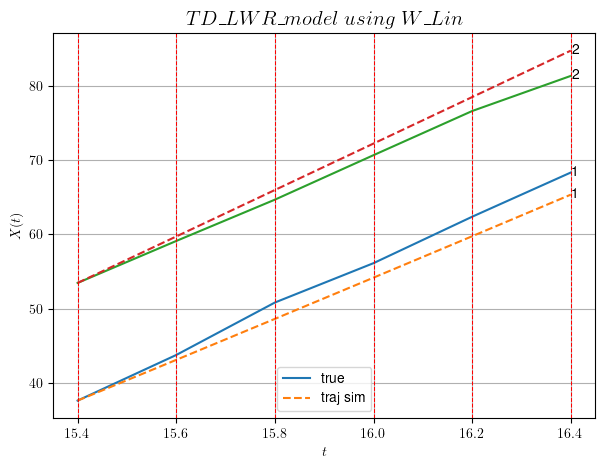

In [8]:
## Matching..
t_list_matched, x_list_matched = match_timestamps_scene(t_list, x_list)

# plot function
tscale = 1+(tstamps[-1]-tstamps[0])/10000
title = rf"$TD\_LWR\_model\ using\ W\_{flag}$"
plot_scn(scn, x_list_matched, title, xbal=0.01, ybal=0.05, scale=tscale)